In [1]:
import sys
sys.path.append('../')

import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.datagen as dg
import cqt.dbutility.dbutility as db
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import copy
import cqt.strats.StrategyTensorFlow as stg_tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### db.get_table_list() method takes 1 argument db_id, and is defaulted to 'Amazon_RDS'
df_tbl_list=db.get_table_list()
print(df_tbl_list)

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


                                   table_name
0    coinapi-ohlcv-BINANCE_SPOT_BTC_USDT-1DAY
1    coinapi-ohlcv-BINANCE_SPOT_ETH_USDT-1DAY
2    coinapi-ohlcv-COINBASE_SPOT_LTC_USD-1DAY
3    coinapi-ohlcv-BINANCE_SPOT_ADA_USDT-1DAY
4         coinapi-ohlcv-DSX_SPOT_ETH_USD-1DAY
5      coinapi-ohlcv-KRAKEN_SPOT_XLM_USD-1DAY
6         coinapi-ohlcv-DSX_SPOT_LTC_USD-1DAY
7   coinapi-ohlcv-BINANCE_SPOT_IOTA_USDT-1DAY
8      coinapi-ohlcv-GEMINI_SPOT_BTC_USD-1DAY
9    coinapi-ohlcv-BINANCE_SPOT_EOS_USDT-1DAY
10        coinapi-ohlcv-DSX_SPOT_BCH_USD-1DAY
11     coinapi-ohlcv-KRAKEN_SPOT_EOS_USD-1DAY
12     coinapi-ohlcv-KRAKEN_SPOT_BCH_USD-1DAY
13     coinapi-ohlcv-KRAKEN_SPOT_XRP_USD-1DAY
14   coinapi-ohlcv-BINANCE_SPOT_LTC_USDT-1DAY
15   coinapi-ohlcv-COINBASE_SPOT_BTC_USD-1DAY
16   coinapi-ohlcv-BINANCE_SPOT_BCH_USDT-1DAY
17     coinapi-ohlcv-GEMINI_SPOT_ETH_USD-1DAY
18   coinapi-ohlcv-BINANCE_SPOT_XRP_USDT-1DAY
19     coinapi-ohlcv-KRAKEN_SPOT_ETH_USD-1DAY
20   coinapi-ohlcv-COINBASE_SPOT_B

In [3]:
TODAY = datetime.now()

tbl_name='coinapi-ohlcv-COINBASE_SPOT_BTC_USD-1DAY'
df_btc=db.get_from_db(tbl_name,from_date='2016-01-01',to_date=TODAY.strftime('%Y-%M-%d'))
df_eth = db.get_from_db("coinapi-ohlcv-COINBASE_SPOT_ETH_USD-1DAY",from_date='2016-01-01',to_date=TODAY.strftime('%Y-%M-%d'))



In [4]:
df_btc.data

,price_close,price_open,price_high,price_low,time_close,time_open,trades_count,volume_traded,key,last_updated
0,435.66,430.35,437.15,427.92,2016-01-01T23:59:01.0000000Z,2016-01-01T00:00:16.0000000Z,12169,3863.277451,2016-01-01,2018-07-02 11:51:28.312307
1,435.40,435.67,437.56,432.41,2016-01-02T23:59:23.1200000Z,2016-01-02T00:00:02.0000000Z,11493,3275.441801,2016-01-02,2018-07-02 11:51:28.312307
2,431.91,435.40,435.75,425.02,2016-01-03T23:59:59.8000000Z,2016-01-03T00:00:37.7930000Z,14239,3904.335318,2016-01-03,2018-07-02 11:51:28.312307
3,433.85,431.90,435.79,431.37,2016-01-04T23:59:54.9330000Z,2016-01-04T00:00:34.1730000Z,11331,5893.789223,2016-01-04,2018-07-02 11:51:28.312307
4,433.34,433.84,435.64,430.00,2016-01-05T23:59:31.3770000Z,2016-01-05T00:00:28.7270000Z,13848,5150.109476,2016-01-05,2018-07-02 11:51:28.312307
5,430.87,433.32,433.46,428.15,2016-01-06T23:59:55.6670000Z,2016-01-06T00:00:01.6200000Z,15951,5476.959959,2016-01-06,2018-07-02 11:51:28.312307
6,459.07,430.66,460.15,430.64,2016-01-07T23:59:59.0570000Z,2016-01-07T00:00:02.2870000Z,29221,13907.201729,2016-01-07,2018-07-02 11:51:28.312307
7,454.44,459.07,464.40,447.53,2016-01-08T23:59:32.7770000Z,2016-01-08T00:00:02.2970000Z,20050,8341.783440,2016-01-08,2018-07-02 11:51:28.312307
8,450.38,454.41,456.00,447.66,2016-01-09T23:59:10.8700000Z,2016-01-09T00:00:12.5570000Z,18769,4241.356651,2016-01-09,2018-07-02 11:51:28.312307
9,449.99,450.39,451.39,442.96,2016-01-10T23:59:40.1370000Z,2016-01-10T00:00:01.6270000Z,11582,3954.322400,2016-01-10,2018-07-02 11:51:28.312307


In [5]:
config = {'asset_type': 'spot'}
model_btc_eth = env.MktEnv([])
comp_btc = envspot.MktEnvSpot('btc', df_btc.get_index_data(), config)
model_btc_eth.insert_section(comp_btc)



cash = 10000
assets = {'btc': 0}
ini_pfo = ledger.Ledger(assets, cash)


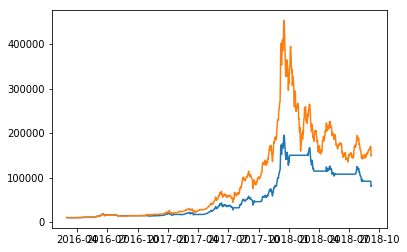

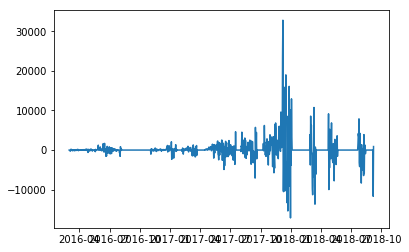

In [16]:
# Long/Short Average
ls_rule = {'method' : 'moving_average', 'window_size' : [15, 30], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_ls.StrategyInverseMA(model_btc_eth, ini_pfo, ls_rule)
start_date_str = '2016-03-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

longShortReport = report.copy()

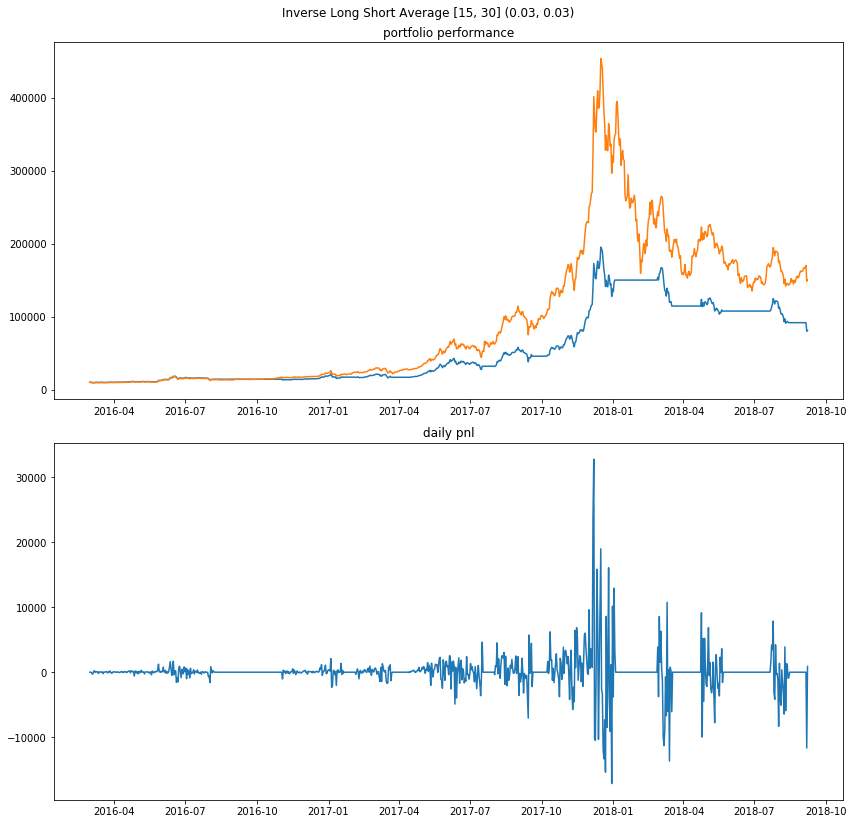

max daily gain: 32793.17132953234
max daily loss: -17142.429305887883


In [17]:
report = longShortReport
outDir='./'

strategyName = 'Inverse Long Short Average [15, 30] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())


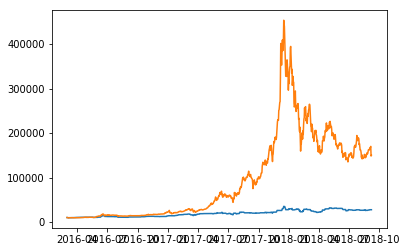

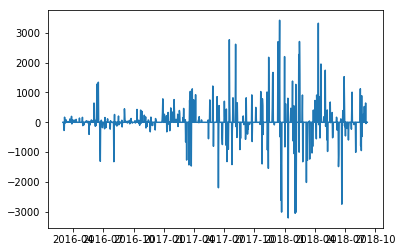

In [19]:
import cqt.strats.strategy_double_dip as stg_dd

# Double Dip Strategy
dd_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_dd.StrategyDoubleDip(model_btc_eth, ini_pfo, dd_rule)
start_date_str = '2016-03-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)


In [20]:
report

,date,total,pnl,cash,set_aside,btc_holding,btc_price
0,2016-03-01,10000.000000,0,10000,0.0,0,433.08
1,2016-03-02,10000.000000,0,10000,0.0,0,420.39
2,2016-03-03,10000.000000,0,0,0.0,23.8777,418.80
3,2016-03-04,9726.599809,-273.4,0,0.0,23.8777,407.35
4,2016-03-05,9457.497612,-269.102,0,0.0,23.8777,396.08
5,2016-03-06,9628.462273,170.965,9628.46,0.0,0,403.24
6,2016-03-07,9628.462273,0,0,0.0,23.3581,412.21
7,2016-03-08,9604.403381,-24.0589,9604.4,0.0,0,411.18
8,2016-03-09,9604.403381,0,9604.4,0.0,0,412.80
9,2016-03-10,9604.403381,0,0,0.0,23.0886,415.98


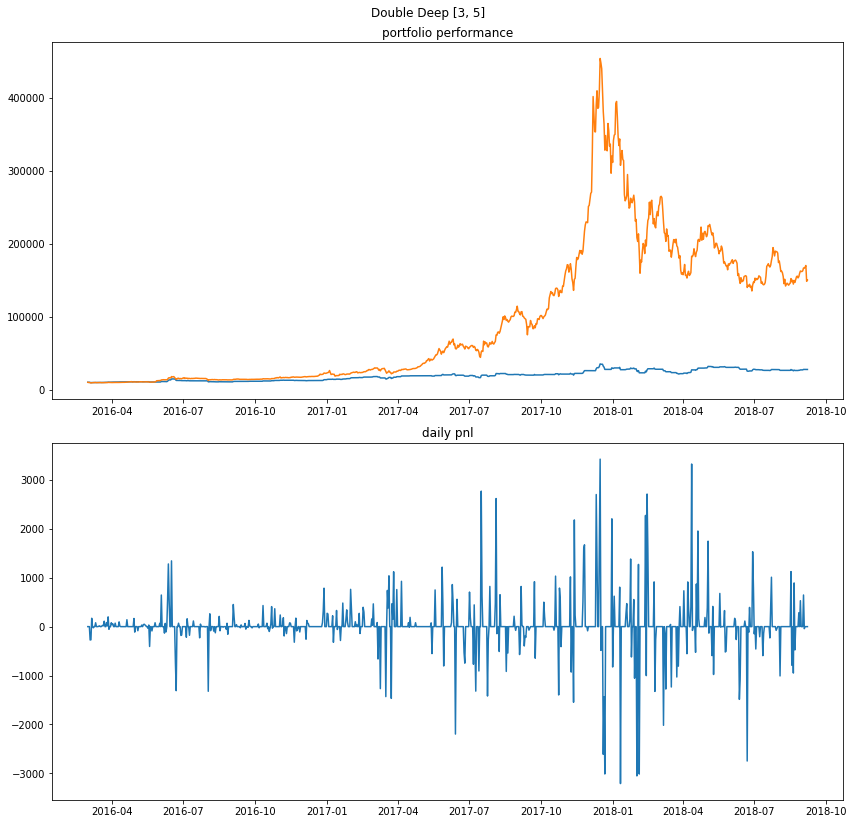

max daily gain: 3423.4190105749767
max daily loss: -3208.374847257266


In [21]:
strategyName = 'Double Deep [3, 5]'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())